The aim of this project will be to model the stellar variability of the Delta Scuti variable star, using timeseries data from the TESS mission to WASP-33b.

A Fourier analysis will be performed first. After that, a Lomb-Scargle periodigram will be produced, since it works best with unevenly sampled data.

The transit signals have already been removed from the dataset.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.fft as fft
import astropy
from scipy.fft import fft, fftfreq
from astropy.timeseries import LombScargle
import statsmodels.api as sm

df = pd.read_csv("wasp-33b_residuals.csv")

Let's examine our dataset.

In [49]:
df

,time,residuals,flux_err
0,2.458792e+06,0.994566,0.001620
1,2.458792e+06,0.996258,0.001618
2,2.458792e+06,0.996416,0.001617
3,2.458792e+06,0.996009,0.001618
4,2.458792e+06,0.996739,0.001617
...,...,...,...
121457,2.459909e+06,1.001545,0.001609
121458,2.459909e+06,1.001408,0.001609
121459,2.459909e+06,1.000594,0.001611
121460,2.459909e+06,1.000998,0.001610


In the figure below that plots residuals versus time, we can see an uneven data set

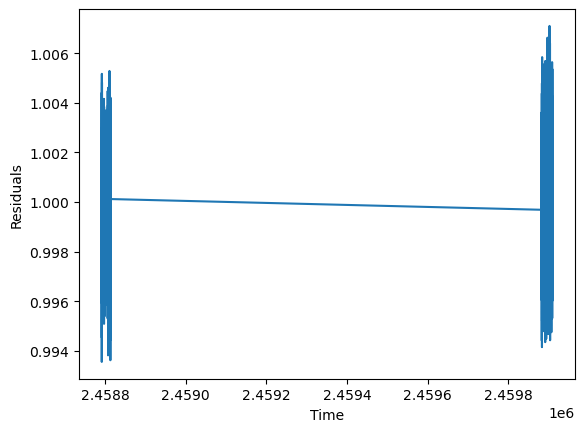

In [50]:
time = df['time']
residuals = df['residuals']
flux_err = df['flux_err']

plt.plot (time,residuals)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

Let's slice our data.

In [51]:
mask = df['time'] < df['time'].mean()

time1 = df['time'][mask]
time2 = df['time'][~mask]

In [52]:
residuals1 = df['residuals'][mask]
residuals2 = df['residuals'][~mask]

In [53]:
flux_err1 = df['flux_err'][mask]
flux_errs2 = df['flux_err'][~mask]

Let's visualize it to see where we are.

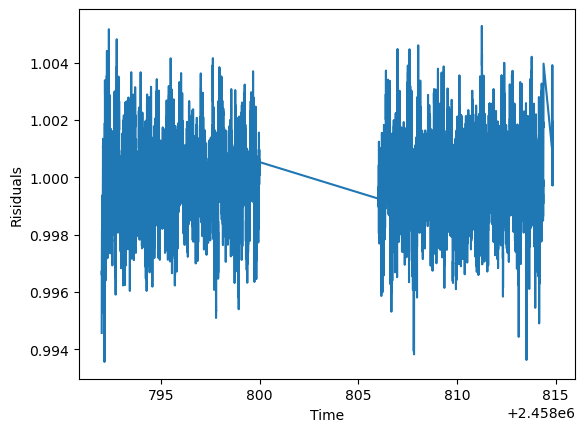

In [54]:
plt.plot(time1,residuals1)
plt.xlabel("Time")
plt.ylabel("Risiduals")
plt.show()

Better, but not quite there! Let's continue slicing.

In [55]:
mask_a = time1 < time1.mean()

time1_a = time1[mask_a]
time2_a = time1[~mask_a]

In [56]:
residuals1_a = residuals1[mask_a]
residuals2_a = residuals1[~mask_a]

In [57]:
flux_err1_a = flux_err1[mask_a]
flux_err2_a = flux_err1[~mask_a]

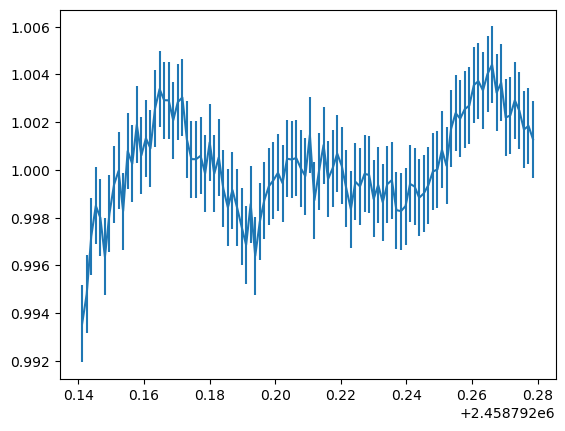

In [58]:
fig, ax = plt.subplots()
ax.errorbar(time1_a[100:200],residuals1_a[100:200], yerr=flux_err1_a[100:200])
plt.show()

Beautiful! Now we have a dataset with which we can work!

The initial attempt at performing a Fourier transform failed. The data needed to be interpolated.

Now to interpolate our data!

In [59]:
min_time = np.min(time1_a)
print(min_time)

2458792.0008442705


In [60]:
max_time = np.max(time1_a)
print(max_time)

2458799.995281831


In [61]:
step = (max_time - min_time)/len(time1_a)

In [62]:
step

0.0014739007301694525

In [63]:
time_interp = np.linspace(min_time,max_time,len(time1_a))
resid_interp = np.interp(time_interp, time1_a, residuals1_a,)

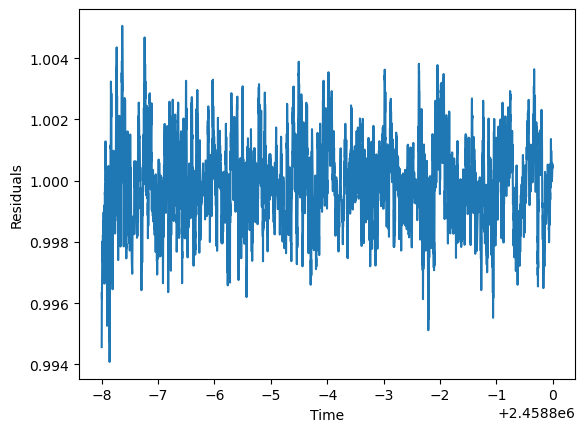

In [64]:
plt.plot(time_interp,resid_interp)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

We're now ready for our Fourier transform!

In [65]:
fourier_residuals = fft(resid_interp)

In [66]:
fourier_frequency = fftfreq(len(time1_a), step)[:len(time1_a)//2] #samples so that only uses real parts

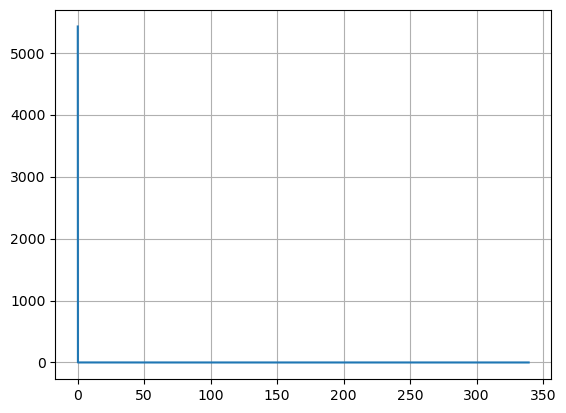

In [67]:
plt.plot(fourier_frequency, np.abs(fourier_residuals[0:len(time1_a)//2]))
plt.grid()
plt.show()

Uh-oh! Let's try to figure out what's wrong. The power seems to predominantly be in the lower frequency, which means that there is no periodic signal

To evaluate, let's take a look at the residuals.

In [68]:
fourier_residuals

array([ 5.42367335e+03-0.j        , -2.51172276e-01-0.07671249j,
       -6.66069813e-02-0.10211613j, ..., -1.58793976e-01-0.06794867j,
       -6.66069813e-02+0.10211613j, -2.51172276e-01+0.07671249j])

Let's ignore the first value. 

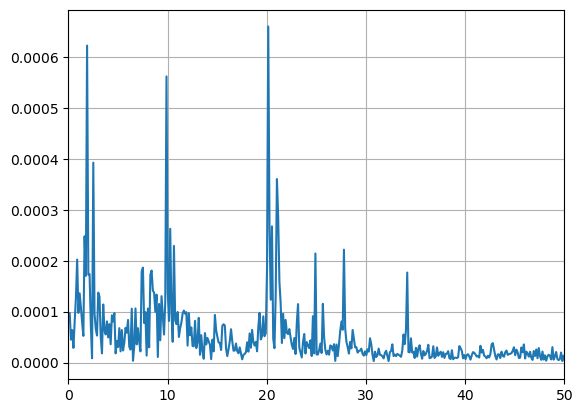

In [69]:
plt.xlim(0,50)
plt.plot(fourier_frequency[1:len(time1_a)//2], 2.0/len(time1_a) * np.abs(fourier_residuals[1:len(time1_a)//2])) #scaled by the frequency
plt.grid()
plt.show() 

Aaah! Much better!

Now, on to the Lomb-Scargle analysis! We'll work on the entire dataset, since the Lomb-Scarle method
is intended for uneven datasets.

Initial attempts found elements of NaN, so first we have to remove them.

In [70]:
num_time = time[~np.isnan(time)]
num_residuals = residuals[~np.isnan(time)]
num_fluxerr = flux_err[~np.isnan(time)]

An initial check showed that elements of NaN appeared more in time than residuals, so we had to adjust accordingly. The new check shows they are now equal arrays of equal length without elements of NaN.

In [71]:
print(len(num_time))
print(len(num_residuals))
print(len(num_fluxerr))

121180
121180
121180


What an enormous dataset!

In [72]:
print(len(time))
print(len(residuals))
print(len(num_fluxerr))

121462
121462
121180


Let's build our periodogram.

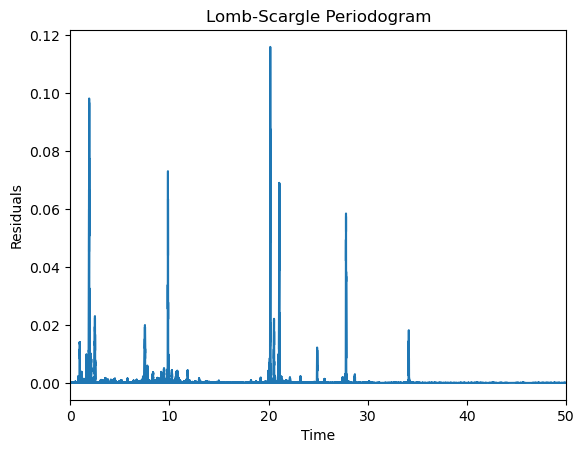

In [74]:
plt.xlim(0,50)
plt.plot(LS_time,LS_residuals)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Lomb-Scargle Periodogram")
plt.show()

This is interesting, because it shows similar results to the Fourier analysis that was conducted on only a small slice of the data, and yet the periods seem to be similar.

Our next step is to specify the frequency.

In [75]:
LS_time1, LS_residuals1 = LombScargle(num_time, num_residuals).autopower(nyquist_factor=2)#half the cycle over the sample
len(LS_time1), LS_time1.min(), LS_time1.max()

#Test is for any periodicity between 13 minutes and 30 years.

(605901, 8.94855303372276e-05, 108.43865514818275)

Let's try evaluating the periodigram at 100 points.

We'll begin with the tallest peak.

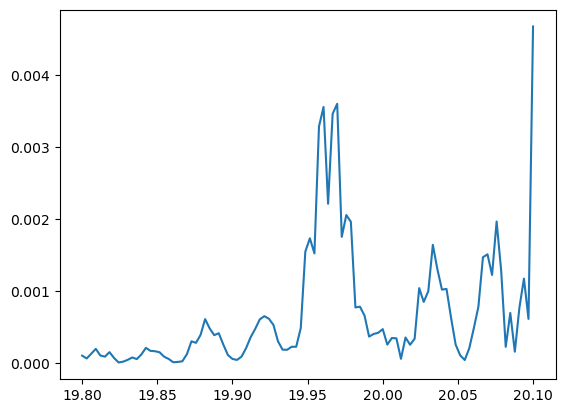

In [83]:
three_LS_time100 = np.linspace(19.8, 20.1, 100)
three_LS_residuals100 = LombScargle(num_time, num_residuals).power(three_LS_time100)
plt.plot(three_LS_time100, three_LS_residuals100) 
plt.show()

Let's try a samples per peak argument.

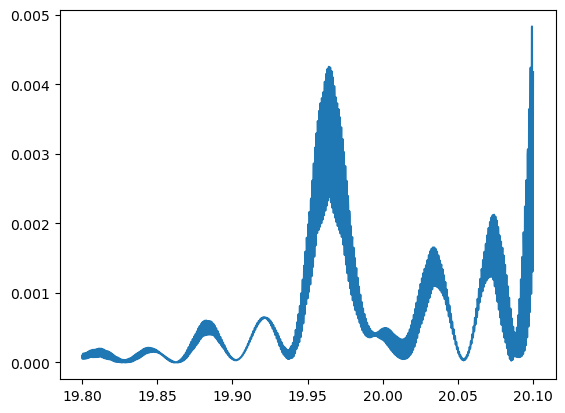

In [84]:
three_LS_time2, three_LS_residuals2 = LombScargle(num_time, num_residuals).autopower(minimum_frequency=19.8,
                                                   maximum_frequency=20.1)
len(three_LS_time2)

plt.plot(three_LS_time2, three_LS_residuals2)  
plt.show()

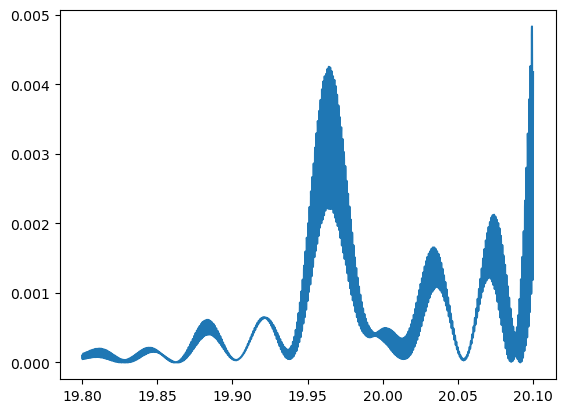

In [85]:
three_LS_time3, three_LS_residuals3 = LombScargle(num_time, num_residuals).autopower(minimum_frequency=19.8,
                                                   maximum_frequency=20.1,
                                                   samples_per_peak=10)
len(three_LS_time3)
plt.plot(three_LS_time3, three_LS_residuals3)  
plt.show()

In [44]:
print(np.max(LS_residuals3))#calculates the period
print(np.argmax(LS_residuals3))#argmax

0.09914178677668174
1135


In [103]:
phase = (num_time/LS_time[np.argmax(LS_residuals)]) - (np.floor(num_time/LS_time[np.argmax(LS_residuals)]))
print(phase)

0         0.084393
1         0.084462
2         0.084531
3         0.084600
4         0.084668
            ...   
121457    0.514576
121458    0.514587
121459    0.514598
121460    0.514610
121461    0.514621
Name: time, Length: 121180, dtype: float64


Now to construct the Lomb-Scargle periodigram sinusoidal model

In [76]:
minper = (30/60/24) #define minimum and maximum period range
maxper = 30 #in days

In [77]:
ls = LombScargle(num_time, num_residuals, dy=num_fluxerr) #thanks for the code, Kyle!
freq, power = ls.autopower(maximum_frequency=1. / minper, minimum_frequency=1. / maxper, nyquist_factor=2)
#search residuals for periodic signals

Just for fun, let's perform a false alarm check. 

In [86]:
LS_time, LS_residuals = LombScargle(num_time, num_residuals, num_fluxerr).autopower()
ls.false_alarm_level((6e-7), method='baluev')

array(0.00047229)

Working with enormous amounts of data!

In [78]:
# Phase fold data at max peak/data transformation/convert from frequency into period
mi = np.argmax(power) 
per = 1. / freq[mi]
newphase = num_time / per % 1
periods = 1. / freq
print(per)
period_hours = per*24
print(period_hours)

0.04959509976875625
1.19028239445015


Our test shows that the model is accurate, since WASP-33b's period is in fact 1.2 days.

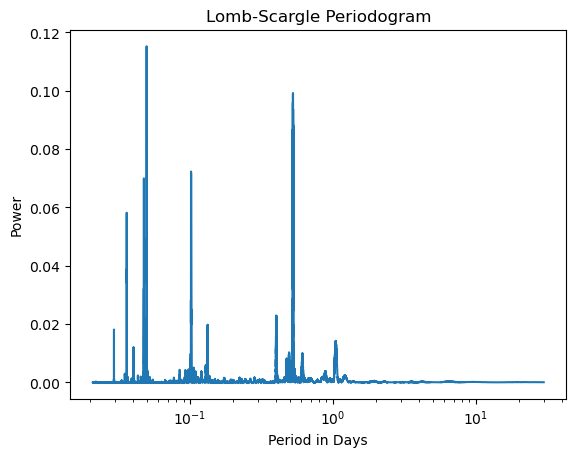

In [79]:
plt.semilogx(periods,power)
plt.xlabel("Period in Days")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

Let's construct the best fit signal at this period using linear least squares regression -- which is a weighted sum.

In [80]:
#create basis vectors for Tn = T0 + n*P + Asin(wn) + Bcos(wn)

basis = np.ones((4, len(num_time)))
basis[1] = num_time
basis[2] = np.sin(2 * np.pi * num_time / per)
basis[3] = np.cos(2 * np.pi * num_time / per)

#derive coefficients/weighted sum. Setting up vectors to do a big matrix multiplication, to 
#derive final values for the amplitude to estimate variability.

In [81]:
#perform the weighted least squares regression

res_first_order = sm.WLS(num_residuals, basis.T, weights=1.0 / num_fluxerr ** 2).fit()
coeffs_first_order = res_first_order.params
y_bestfit_first_order = np.dot(basis.T, coeffs_first_order)  # reconstruct signal
residuals_first_order = num_residuals - y_bestfit_first_order #looks for other periodic signals/subtracts second signal

We're now ready to construct a phase diagram.

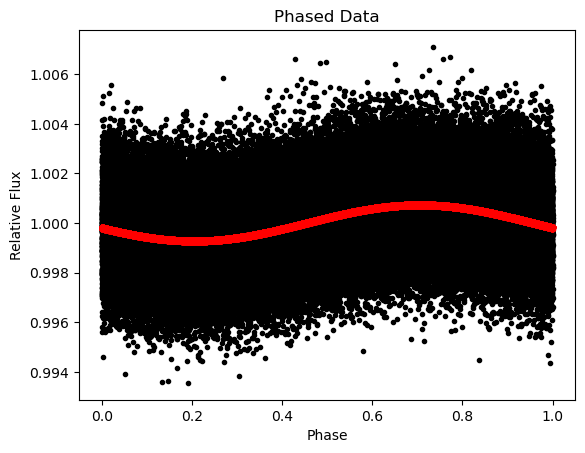

In [82]:
#plotting the best signal
#deriving the amplitude to estimate how strong the signal is

si = np.argsort(newphase)
plt.plot(newphase,num_residuals,"k.")
plt.plot(newphase,y_bestfit_first_order,"r.")
plt.xlabel("Phase")
plt.ylabel("Relative Flux")
plt.title("Phased Data")
plt.show()

# Next steps: take this code, writing into a function to make these plots for a lot of different targets
# Add tweaks to the plots -- like a second period. 

The next step is to take the first order, run LS again, see another peak. Periodogram plot. Power vs Periodicity.

In addition, it would be to write a function to make it viable for many different targets, thus allowing the Exoplanet Watch project to be even more efficient and successful.

Thank you for taking this stellar journey with me, everyone!

Special thanks to Josh Tan, Rob Zellem, and Kyle Pearson for all their help!